In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [3]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3486, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 3486 (delta 31), reused 28 (delta 14), pack-reused 3428
Receiving objects: 100% (3486/3486), 56.30 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (3179/3179), done.
Checking out files: 100% (5390/5390), done.
/content/LIDC_GDRO


In [75]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/mtzig/LIDC_GDRO
   1e42c8b..4718416  main       -> origin/main
Updating 1e42c8b..4718416
Fast-forward
 data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv | 1 -
 1 file changed, 1 deletion(-)


In [5]:
import data_util
import datasets
import dataloaders
import models
import torch
import loss
import train
import pandas as pd
import numpy as np
from torchvision import transforms

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 128
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.01, "mix_eta": 0.05}
lr = 0.00001
weight_decay = 0.005

model_class = models.TransferModel
model_args = (True, False, True, device)

device

'cuda'

# Load and process data

## LIDC

In [ ]:
# get LIDC data

df = data_util.preprocess_data(*data_util.load_lidc())
df

,noduleID,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,...,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,malignancy,subgroup
0,1,2.856616,2.857401,2.687800,2.513946,2.528996,2.146283,2.819337,-0.565107,1.327377,...,-0.948570,1.198701,1.948371,-0.230542,1.114230,0.607925,-0.055895,0.056667,1,marked_malignant
1,2,2.266651,1.912920,1.548101,1.949929,2.170529,2.077030,1.908635,0.376664,-0.175769,...,-0.912648,1.412920,1.618909,-0.051489,1.091476,-1.139806,-0.639256,-0.637140,1,unmarked_malignant
2,3,2.310228,2.225867,2.188746,2.037840,2.198122,1.867890,2.188392,-0.252713,0.955155,...,-0.930609,1.443523,1.846998,-0.240671,1.387277,-0.459891,-0.225139,-0.140400,1,marked_malignant
3,4,-0.270867,-0.297450,-0.158212,-0.120437,-0.102513,-0.022481,-0.247999,0.716455,-0.134097,...,-0.517510,-0.147818,0.157451,-0.262647,-0.205499,-0.442457,-0.290192,-0.282093,1,marked_malignant
4,5,0.014059,-0.060624,0.019092,0.140032,0.284178,-0.004912,0.478577,-1.036129,-0.499655,...,-0.679157,2.618667,0.495361,-0.097119,3.036939,0.189516,-0.087629,-0.023137,1,unmarked_malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,2686,0.882245,1.106586,1.494742,1.550334,1.160330,1.338284,1.418390,-0.001920,1.674251,...,-0.912648,0.580526,1.576671,-0.274712,0.295088,-0.141725,-0.082340,0.006179,1,marked_malignant
2682,2687,-0.247403,-0.263617,-0.109727,-0.095528,-0.067287,-0.007203,-0.166452,0.480382,-0.048421,...,-0.517510,1.137496,0.174347,-0.242588,1.068722,-1.292351,-0.634496,-0.624110,1,marked_malignant
2683,2688,-0.619483,-0.596301,-0.689113,-0.741530,-0.765808,-0.712714,-0.767747,0.061446,-0.304231,...,0.542181,-0.857801,-0.839381,0.116431,-1.092903,-0.246327,-0.262161,-0.300008,0,unmarked_benign
2684,2689,-0.609427,-0.596301,-0.677349,-0.736938,-0.740491,-0.789406,-0.652776,-0.813723,-0.347434,...,0.380533,0.164330,-0.738009,-0.267228,-0.398907,-1.314143,-0.718588,-0.746259,0,unmarked_benign


In [ ]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_split_stratified.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

## Waterbirds

In [7]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 7.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 3.1 MB 42.1 MB/s 
     |████████████████████████████████| 78 kB 5.2 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=cd4081d8d5cefa46ada3e558343625e116960bbdd3e3495867e91fefb23666ac
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all t

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]

Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 0.51 minutes to download and uncompress the dataset.



In [8]:
from PIL import Image

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'DeferredError' from 'PIL._util' (/usr/local/lib/python3.7/dist-packages/PIL/_util.py)
]
[autoreload of scipy.sparse.sputils failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'prod' from 'scipy._lib._util' (/usr/local/lib/python3.7/dist-packages/scipy/_lib/_util.py)
]
[autoreload of scipy.sparse.coo failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'getdata' from 'scipy.sparse.sputils' (/usr/local/lib/python3

In [9]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [10]:
# this one takes a while

convert_resize = transforms.Compose([transforms.ToTensor(), transforms.Resize((50, 50), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

for df in [train_df, val_df, test_df]:
    image_tensors = []
    for image_path in df['img_filename']:
        image_tensors.append(convert_resize(Image.open('data/waterbirds_v1.0/' + image_path)))

    X = torch.stack(image_tensors).to(device)
    y = torch.LongTensor(df['y'].values).to(device)
    c = torch.LongTensor((2 * df['y'] + df['place']).values).to(device)
    
    dataset_list.append(datasets.SubclassedNoduleDataset(X, y, c))

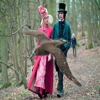

In [40]:
Image.open('data/waterbirds_v1.0/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg').resize((100, 100))

In [28]:
# smaller dataloaders for prototyping
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(int(0.5 * len(dataset)))), batch_size=batch_size) for dataset in dataset_list]

In [24]:
# full size dataloaders
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [58]:
N = 1
epochs = 30
# subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO"]
keep_old =        [False, False]

if not sum(keep_old):
  results = {}

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
      print(f"Keeping old results for {algorithm}")
    else:
      print(f"Running test: {algorithm}")

      results[algorithm] = np.zeros(N * epochs * len(subtypes))

      # create the training and testing dataloaders
  #     if algorithm == "ERM":
  #         train_dataloader = data_util.create_dataloader(training_df, batch_size)
  #     else:
  #         train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
  #     test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)
      
      # train_dataloader = data_util.create_dataloader(training_df, batch_size)
      # test_dataloader = data_util.create_dataloader(test_df, batch_size)

      for n in range(N):

          print(f"Trial {n + 1}/{N}")

          # create and train model
          # model = models.NeuralNetwork(64, 32, 32, 2)
          # model.to(device)
          model = model_class(*model_args)

          if (algorithm == "ERM"):
              loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
          elif (algorithm == "GDRO"):
              loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], 4, normalize_loss=False)
          elif (algorithm.startswith("GDRO")):
              loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), 4, normalize_loss=True)
          elif (algorithm == "Dynamic"):
              loss_fn = loss.DynamicERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], hparams["mix_eta"], 4, normalize_loss=True, subclassed=True)
          elif (algorithm.startswith("Dynamic")):
              loss_fn = loss.DynamicERMGDROLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["mix_eta"], 4, normalize_loss=True, subclassed=True)
          else:
              loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4, normalize_loss=True, subclassed=True)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

          for epoch in range(epochs):
              print(f'Epoch {epoch + 1} / {epochs}')

              if algorithm == "Sharp":
                  loss_fn.t = epoch / epochs < 0.5  # sharp boundary
              elif algorithm == "Smooth":
                  loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
              elif algorithm == "ReverseSmooth":
                  loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
              elif algorithm == "ExtraERM":
                  loss_fn.t = 2
              elif algorithm == "ExtraGDRO":
                  loss_fn.t = -1
              elif algorithm == "Halfway":
                  loss_fn.t = 0.5
              elif algorithm.startswith("Mix"):
                  loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

              train.train(train_dataloader, model, loss_fn, optimizer)
              sensitivities = train.test(test_dataloader, model)
              print(sensitivities)

              for i in range(len(subtypes)):
                  results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/1
Epoch 1 / 30
(0.353515625, 0.0755813953488372, 0.0, 0.898989898989899, 0.9518072289156626)
Epoch 2 / 30
(0.390625, 0.29444444444444445, 0.037037037037037035, 0.6777777777777778, 1.0)
Epoch 3 / 30
(0.44921875, 0.5833333333333334, 0.07142857142857142, 0.4731182795698925, 0.956989247311828)
Epoch 4 / 30
(0.509765625, 0.7045454545454546, 0.16233766233766234, 0.3191489361702128, 0.9318181818181818)
Epoch 5 / 30
(0.53125, 0.8435754189944135, 0.18354430379746836, 0.24242424242424243, 0.8947368421052632)
Epoch 6 / 30
(0.5234375, 0.7944444444444444, 0.21739130434782608, 0.1797752808988764, 0.9024390243902439)
Epoch 7 / 30
(0.5546875, 0.8763440860215054, 0.18633540372670807, 0.18518518518518517, 0.9047619047619048)
Epoch 8 / 30
(0.513671875, 0.88125, 0.1949685534591195, 0.16346153846153846, 0.8314606741573034)
Epoch 9 / 30
(0.564453125, 0.8963414634146342, 0.2662337662337662, 0.14736842105263157, 0.8787878787878788)
Epoch 10 / 30
(0.529296875, 0.9202453987730062, 0.21

In [59]:
trial_means = results_df.unstack().unstack().mean().unstack(level=0).unstack(level=1).stack()
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM      GDRO
subtype      epoch                    
Land on land 0      0.075581  0.522293
             1      0.294444  0.560000
             2      0.583333  0.585714
             3      0.704545  0.660819
             4      0.843575  0.659341
...                      ...       ...
Worst        25     0.134831  0.166667
             26     0.164835  0.262136
             27     0.122449  0.219048
             28     0.084211  0.271739
             29     0.090000  0.168421

[180 rows x 2 columns]

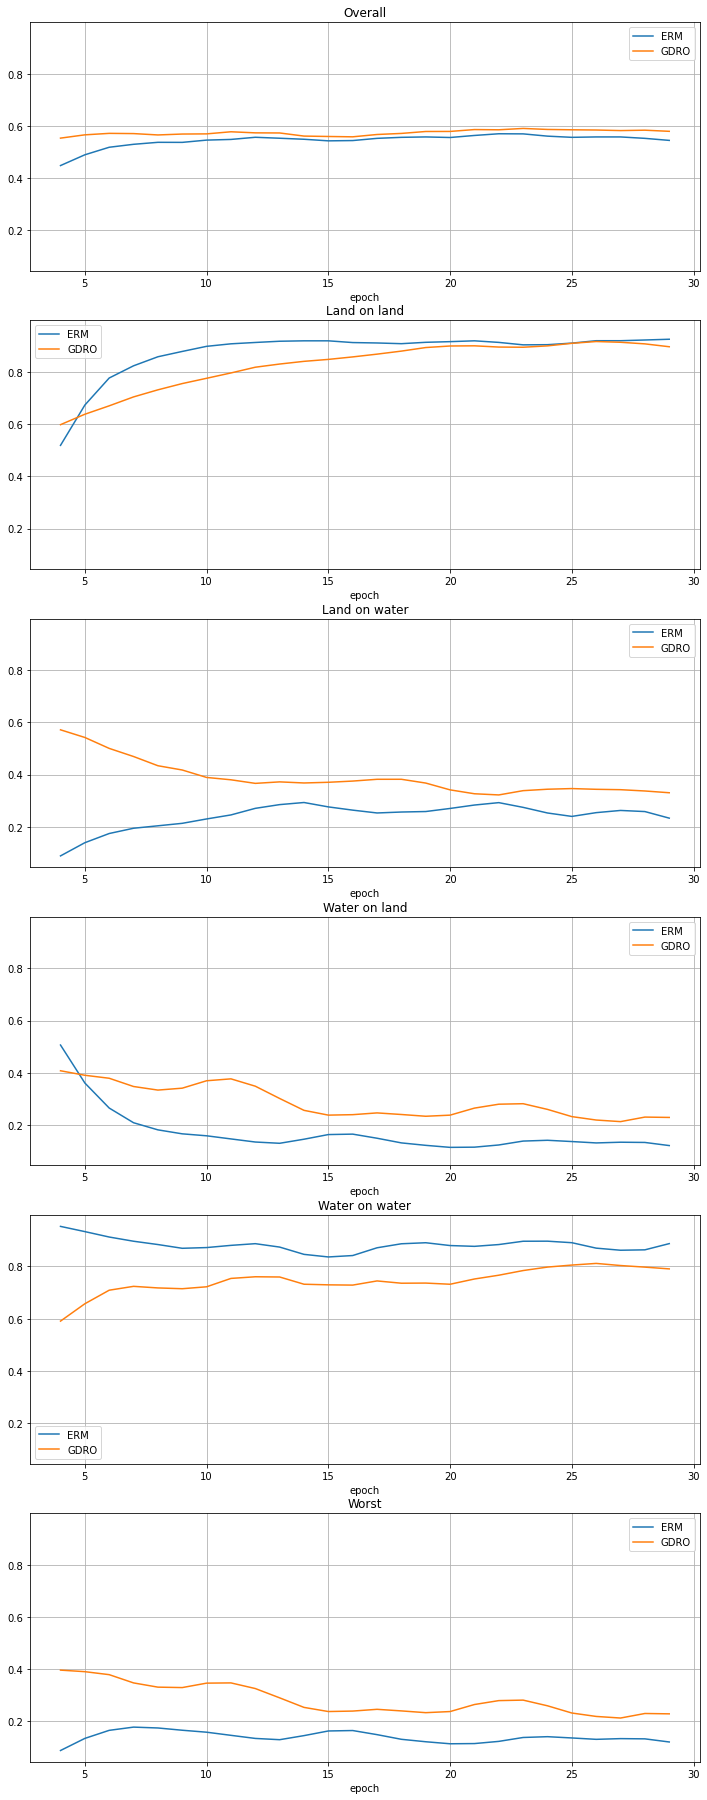

In [60]:
import matplotlib.pyplot as plt

rolling_window = 3

rolling_data = worst_concat.unstack(level=0).rolling(rolling_window).mean().unstack().unstack(level=0)

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots),1, sharey=True)
# plot subtypes sensitivity
for i in range(len(plots)):
    rolling_data.drop(columns=hide).rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(12,32),grid=True)

In [ ]:
worst_concat.to_csv('test_results/dynamic_mix_eta_sweep.csv')

In [ ]:
worst_concat = pd.read_csv('test_results/dynamic_mix_eta_sweep.csv')
worst_concat.index = pd.MultiIndex.from_product([subtypes + ["Worst"], worst_concat["epoch"].unique()])
worst_concat.drop(columns=["subtype", "epoch"], inplace=True)
worst_concat

ERM      GDRO  Dynamic0  Dynamic0.01  Dynamic0.05  \
Overall 0   0.788875  0.787625  0.775625     0.784625     0.781000   
        1   0.799625  0.807875  0.803250     0.802250     0.801250   
        2   0.808125  0.799750  0.797000     0.794250     0.796000   
        3   0.807625  0.803125  0.810125     0.807500     0.801000   
        4   0.821250  0.796750  0.805625     0.806625     0.804250   
...              ...       ...       ...          ...          ...   
Worst   25  0.718508  0.759779  0.704536     0.687693     0.697787   
        26  0.700297  0.733547  0.703048     0.692267     0.706228   
        27  0.687522  0.739087  0.714695     0.736552     0.715319   
        28  0.709425  0.734277  0.697551     0.731143     0.731554   
        29  0.692524  0.736619  0.712036     0.663103     0.697749   

            Dynamic0.1  Dynamic0.5  
Overall 0     0.774250    0.788625  
        1     0.795750    0.799500  
        2     0.807250    0.801250  
        3     0.797500    0.804500  
        4     0.807250    0.811125  
...                ...         ...  
Worst   25    0.682214    0.706921  
        26    0.705715    0.719123  
        27    0.735549    0.739774  
        28    0.701306    0.706858  
        29    0.712782    0.732940  

[180 rows x 7 columns]

# GDRO Demonstration

In [54]:
epochs = 30
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = model_class(*model_args)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1, normalize_loss=True, subclassed=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn.t = 0

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

In [55]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

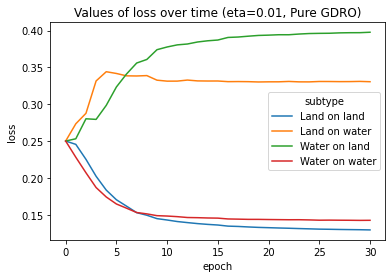

In [56]:
q_df.plot(xlabel="epoch", ylabel="loss", title=f"Values of loss over time (eta={hparams['groupdro_eta']}, Pure GDRO)")

# Old data

In [ ]:
# data for test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# N = 50, epochs = 20
all_data

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)

,InstanceID,StudyInstanceUID,SeriesInstanceUid,RadiologistID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,...,CNN_27,CNN_28,CNN_29,CNN_30,CNN_31,CNN_32,CNN_33,CNN_34,CNN_35,CNN_36
0,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,...,-5.395743,1.582677,-4.063280,-5.070021,3.163702,5.290330,-2.523472,3.713529,-0.649701,4.314638
1,75,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,4,2,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1....,1,1,6,...,-5.850334,5.002493,-3.661947,-3.624461,3.235335,-3.922062,-2.210064,6.059101,-0.500276,5.508437
2,134,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,...,-4.822973,2.920556,-5.047228,-5.552570,3.489042,0.851557,-2.870659,6.073289,-0.647323,6.486247
3,143,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,...,-7.574823,7.260141,-6.138217,-6.386428,4.904528,-2.540447,-2.647656,8.163655,-0.035022,8.056358
4,118,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,3,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,...,-7.165000,6.356084,-6.882338,-5.712488,5.102713,-2.921033,-2.749318,9.136231,-0.171229,8.867806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,30321,1.3.6.1.4.1.14519.5.2.1.6279.6001.112366982107...,1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727...,2,2686,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0770\1.3.6.1....,5,1,6,...,-4.363398,1.216722,-3.386296,-4.855748,2.966221,5.028000,-2.105534,4.931665,-0.734520,4.226719
2682,32539,1.3.6.1.4.1.14519.5.2.1.6279.6001.213747445868...,1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...,2,2687,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0815\1.3.6.1....,4,1,6,...,-5.684091,4.747817,-3.803551,-3.821561,3.346258,-2.903088,-2.005761,5.487472,-0.402588,5.502116
2683,35559,1.3.6.1.4.1.14519.5.2.1.6279.6001.323769537371...,1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046...,4,2688,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0871\1.3.6.1....,4,1,6,...,0.528109,-2.443759,3.613519,5.157967,-0.401557,-2.264581,4.815277,-1.387713,-0.522287,-1.254572
2684,37212,1.3.6.1.4.1.14519.5.2.1.6279.6001.232772963487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785...,4,2689,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0916\1.3.6.1....,1,1,6,...,1.710828,-2.952641,4.176023,7.256946,-0.778750,-2.928508,6.510663,-2.376418,-0.569608,-1.775246


In [ ]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

In [76]:
maxslice_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [77]:
correct_semantic_df = pd.read_csv('data/LIDC_labels.csv')

In [78]:
correct_semantic_df.index = correct_semantic_df['noduleID'].values

In [79]:
for i in maxslice_df.index:
  maxslice_df.loc[i, ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']] = correct_semantic_df.loc[maxslice_df.at[i, 'noduleID'], ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']].values

In [82]:
maxslice_df[['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']]

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1.0,6.0,3,4,3,5,5,5.0
1,2,1.0,6.0,4,2,1,1,2,5.0
2,5,1.0,6.0,4,3,2,2,4,5.0
3,4,1.0,6.0,4,4,1,2,5,4.0
4,4,1.0,6.0,5,5,1,1,5,4.0
...,...,...,...,...,...,...,...,...,...
2682,4,1.0,6.0,2,5,2,2,4,4.0
2683,3,1.0,6.0,3,4,1,1,5,2.0
2684,3,1.0,6.0,5,4,1,1,4,2.0
2685,5,1.0,6.0,3,5,3,2,5,5.0


,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1,6,3,3,3,4,5,5.0
1,1,1,6,3,2,1,1,2,5.0
2,5,1,6,5,4,1,5,4,5.0
3,3,1,6,5,5,1,1,5,4.0
4,4,1,6,4,5,1,1,5,5.0
...,...,...,...,...,...,...,...,...,...
2682,4,1,6,2,5,2,2,4,4.0
2683,4,1,6,4,5,1,1,5,2.0
2684,1,1,6,5,2,1,1,2,2.0
2685,5,1,6,3,4,3,2,5,5.0


In [84]:
maxslice_df.to_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')